In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.time import Time

## 15 - 30 keV (ISGRI)

Distribution of Jupiter ScWs

<Figure size 1000x600 with 0 Axes>

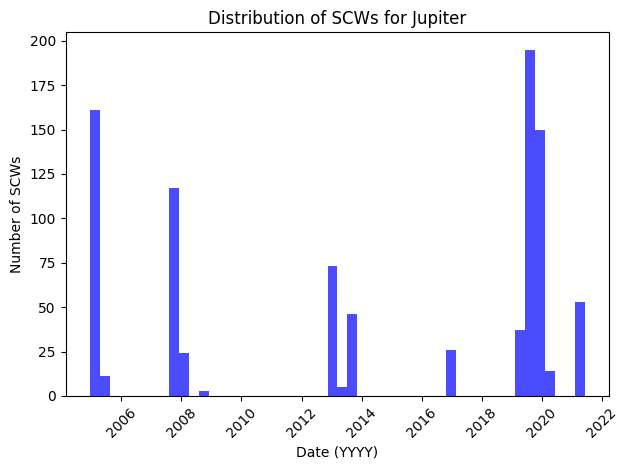

<Figure size 1000x600 with 0 Axes>

In [2]:
scwdates = []

for file in os.listdir('../data/Jupiter/15-30keV/Images/'):
    if file.endswith('.fits'):
        with fits.open(os.path.join('../data/Jupiter/15-30keV/Images/', file)) as hdul:
            scwdates.append(hdul[2].header['DATE-OBS'])

scwdates = [Time(date, format='isot').datetime for date in scwdates]

plt.figure()
plt.hist(scwdates, bins=50, color='blue', alpha=0.7)
plt.xlabel('Date (YYYY)')
plt.ylabel('Number of SCWs')
plt.title('Distribution of SCWs for Jupiter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.figure(figsize=(10, 6))


From the FITS files

In [3]:
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [4]:
# ISGRI: 15 - 30 keV
cr1, vr1, sg1, xp1, acr1, avr1, cr1_cpsf, cr1_psf, err1_cpsf, err1_psf, date1, offset1 = loadJupiterIMG(path='../data/Jupiter/15-30keV/Images', scw_path='../data/jupiter_table.dat')

/home/hthums/master_projects/jupiter-xray-analysis/jupiter-xrays/utils.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(Gaussian2D, xy, z, p0=[cr, x_int, y_int,  np.sqrt(vr),  np.sqrt(vr), 0, 0])


In [5]:
len(cr1)

503

Light curves

Max value of cr1: 16.801088333129883
Index of max value of cr1: 205
File name of max value of cr1: ../data/Jupiter/15-30keV/Images/027300060010.001mosaic.fits
Date of max value of cr1: 2019-02-20 15:52:51


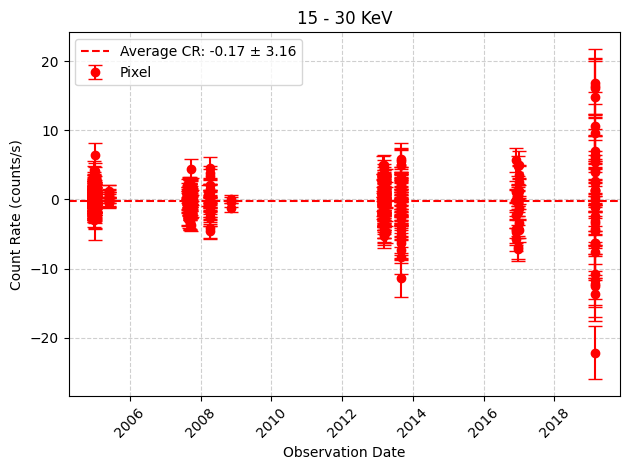

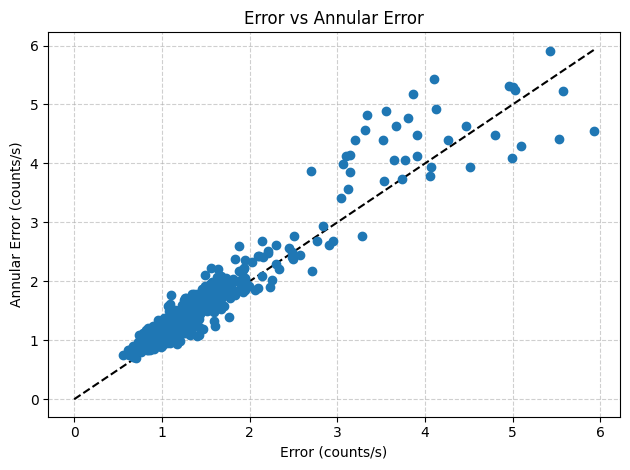

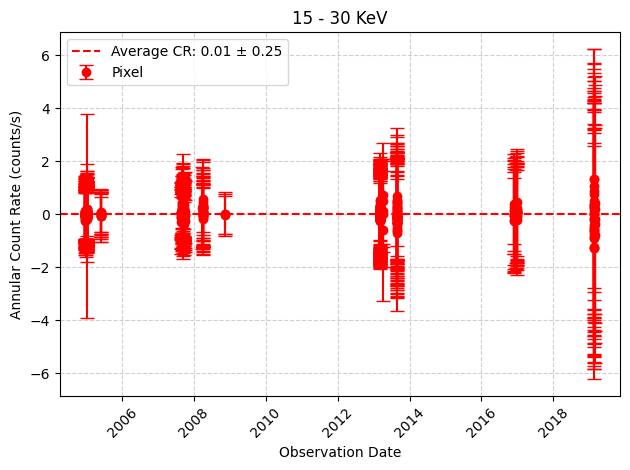

In [151]:
import matplotlib.pyplot as plt

img_times1 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in date1]

# Calculate averages and standard deviations
avg_cr1 = np.mean(cr1)
std_cr1 = np.std(cr1)
avg_psf1 = np.mean(cr1_psf)
std_psf1 = np.std(cr1_psf)
avg_cpsf1 = np.mean(cr1_cpsf)
std_cpsf1 = np.std(cr1_cpsf)
avg_acr1 = np.mean(acr1)
std_acr1 = np.std(acr1)

# Max value
print("Max value of cr1:", np.max(cr1))
print("Index of max value of cr1:", np.argmax(cr1))
files = glob.glob(f'../data/Jupiter/15-30keV/Images/*')
max_file = files[np.argmax(cr1)]
print("File name of max value of cr1:", max_file)
print("Date of max value of cr1:", img_times1[np.argmax(cr1)])

# Plot count rate over time with errorbars and std region
plt.figure()

plt.errorbar(img_times1, cr1, yerr=np.sqrt(vr1), color='r', fmt='o', capsize=5, label='Pixel')
#plt.errorbar(img_times1, cr1_psf, yerr=err1_psf, color='g', fmt='o', capsize=5, label='PSF')
#plt.errorbar(img_times1, cr1_cpsf, yerr=err1_cpsf, color='b', fmt='o', capsize=5, label='Constrained PSF')

plt.axhline(avg_cr1, color='r', linestyle='--', label=f'Average CR: {avg_cr1:.2f} ± {std_cr1:.2f}')
#plt.axhline(avg_psf1, color='g', linestyle='-.')
#plt.axhline(avg_cpsf1, color='b', linestyle=':')

plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("15 - 30 KeV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


# Plot error vs annular error
plt.figure()

# straight line
x = np.linspace(0, np.max(np.sqrt(vr1)), 100)
y = x
plt.plot(x, y, color='k', linestyle='--', label='y=x')

plt.errorbar(np.sqrt(vr1), np.sqrt(avr1), fmt='o', capsize=5)

plt.xlabel("Error (counts/s)")
plt.ylabel("Annular Error (counts/s)")
plt.title("Error vs Annular Error")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Plot annular error
plt.figure()

plt.errorbar(img_times1, acr1, yerr=np.sqrt(avr1), color='r', fmt='o', capsize=5, label='Pixel')

plt.axhline(avg_acr1, color='r', linestyle='--', label=f'Average CR: {avg_acr1:.2f} ± {std_acr1:.2f}')

plt.xlabel("Observation Date")
plt.ylabel("Annular Count Rate (counts/s)")
plt.title("15 - 30 KeV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

Signal to noise ratio

Images corresponding to S/N > 3:
Date: 2004-12-29 12:58:24, S/N: 3.265754041168851
File name: ../data/Jupiter/15-30keV/Images/214600350010.001mosaic.fits
Max value: 16.801088333129883
Index of max value: 45
Date of max value: 2004-12-29 12:58:24

Date: 2007-09-13 19:19:53, S/N: 3.5252200108330567
File name: ../data/Jupiter/15-30keV/Images/215300370010.001mosaic.fits
Max value: 16.801088333129883
Index of max value: 54
Date of max value: 2007-09-13 19:19:53

Date: 2019-02-20 15:52:51, S/N: 3.3912835030105812
File name: ../data/Jupiter/15-30keV/Images/027300060010.001mosaic.fits
Max value: 16.801088333129883
Index of max value: 205
Date of max value: 2019-02-20 15:52:51

Date: 2013-03-06 17:24:33, S/N: 3.2417368007296132
File name: ../data/Jupiter/15-30keV/Images/032100290010.001mosaic.fits
Max value: 16.801088333129883
Index of max value: 233
Date of max value: 2013-03-06 17:24:33

Date: 2004-12-29 17:05:51, S/N: 3.0330255523144896
File name: ../data/Jupiter/15-30keV/Images/214100630010

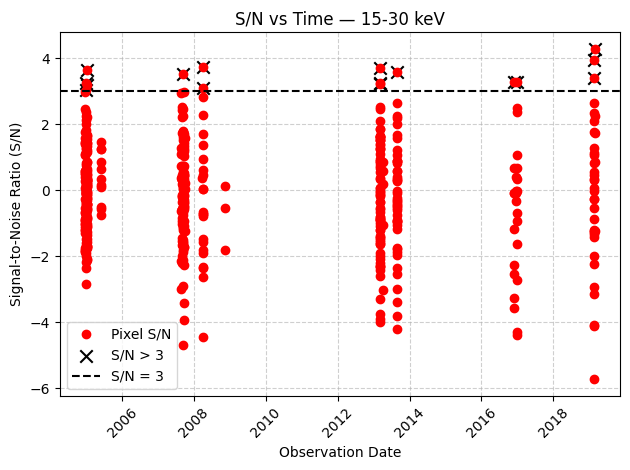

In [7]:
snr_cr1 = np.array(cr1) / np.sqrt(vr1)
annular_snr_cr1 = np.array(cr1_cpsf) / np.sqrt(avr1)

plt.figure()
plt.plot(img_times1, snr_cr1, 'o', color='r', label='Pixel S/N')
#plt.plot(img_times1, annular_snr_cr1, 'o', color='b', label='Annular S/N')

outliers_idx = [i for i, snr in enumerate(snr_cr1) if snr > 3]
plt.scatter(
    [img_times1[i] for i in outliers_idx],
    [snr_cr1[i] for i in outliers_idx],
    marker='x',
    color='k',
    s=80,
    label='S/N > 3'
)

plt.axhline(3, color='k', linestyle='--', label='S/N = 3')

plt.xlabel("Observation Date")
plt.ylabel("Signal-to-Noise Ratio (S/N)")
plt.title("S/N vs Time — 15-30 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

print("Images corresponding to S/N > 3:")
for idx in outliers_idx:
    print(f"Date: {img_times1[idx]}, S/N: {snr_cr1[idx]}")
    print(f"File name: {files[idx]}")
    print(f"Max value: {np.max(cr1)}")
    print(f"Index of max value: {idx}")
    print(f"Date of max value: {img_times1[idx]}")
    print()

Total points: 503
Observed points beyond 3σ: 37
Expected points beyond 3σ: 1.36
Observed fraction: 7.36%
Expected fraction: 0.27%


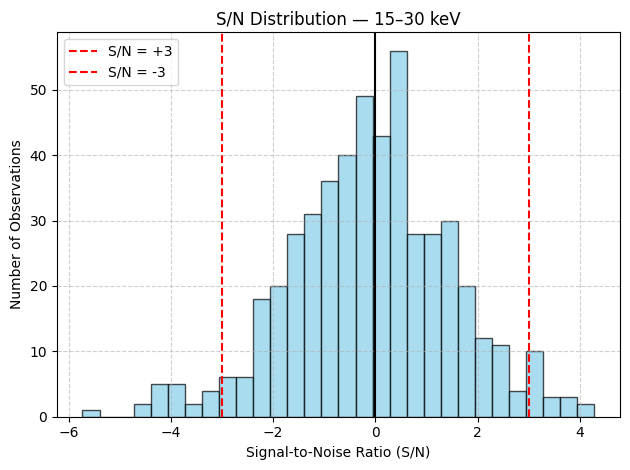

In [8]:
plt.figure()
plt.hist(snr_cr1, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(0, color='k', linestyle='-')
plt.axvline(3, color='r', linestyle='--', label='S/N = +3')
plt.axvline(-3, color='r', linestyle='--', label='S/N = -3')
plt.xlabel("Signal-to-Noise Ratio (S/N)")
plt.ylabel("Number of Observations")
plt.title("S/N Distribution — 15–30 keV")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


snr = np.array(cr1) / np.sqrt(vr1)
outliers = (snr > 3) | (snr < -3)
n_outliers = np.sum(outliers)

n_total = len(snr)
n_expected = 0.0027 * n_total # theoretical fraction of outliers in a normal distribution

print(f"Total points: {n_total}")
print(f"Observed points beyond 3σ: {n_outliers}")
print(f"Expected points beyond 3σ: {n_expected:.2f}")
print(f"Observed fraction: {n_outliers/n_total *100:.2f}%")
print(f"Expected fraction: 0.27%")


Flux conversion

Flux values for S/N > 3:
Date: 2004-12-29 12:58:24, Photon Flux: 5.582e-03 ± 1.709e-03, Energy Flux: 1.850e-10 ± 5.665e-11
File name: ../data/Jupiter/15-30keV/Images/214600350010.001mosaic.fits

Date: 2007-09-13 19:19:53, Photon Flux: 3.661e-03 ± 1.039e-03, Energy Flux: 1.213e-10 ± 3.442e-11
File name: ../data/Jupiter/15-30keV/Images/215300370010.001mosaic.fits

Date: 2019-02-20 15:52:51, Photon Flux: 3.076e-02 ± 9.071e-03, Energy Flux: 1.020e-09 ± 3.007e-10
File name: ../data/Jupiter/15-30keV/Images/027300060010.001mosaic.fits

Date: 2013-03-06 17:24:33, Photon Flux: 7.290e-03 ± 2.249e-03, Energy Flux: 2.416e-10 ± 7.454e-11
File name: ../data/Jupiter/15-30keV/Images/032100290010.001mosaic.fits

Date: 2004-12-29 17:05:51, Photon Flux: 6.332e-03 ± 2.088e-03, Energy Flux: 2.099e-10 ± 6.919e-11
File name: ../data/Jupiter/15-30keV/Images/214100630010.001mosaic.fits

Date: 2013-08-26 18:59:30, Photon Flux: 8.268e-03 ± 2.304e-03, Energy Flux: 2.740e-10 ± 7.637e-11
File name: ../data/Jupiter/

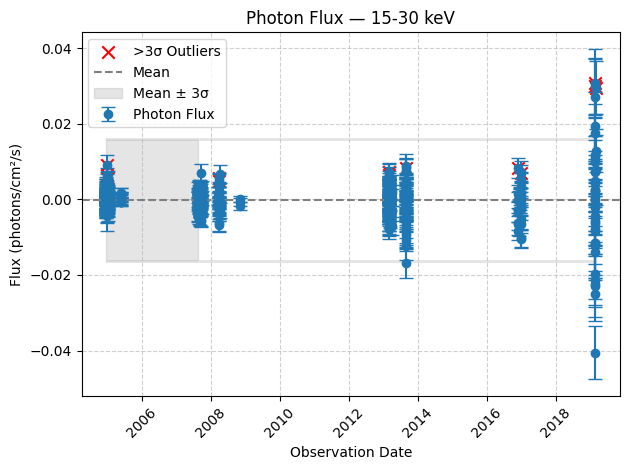

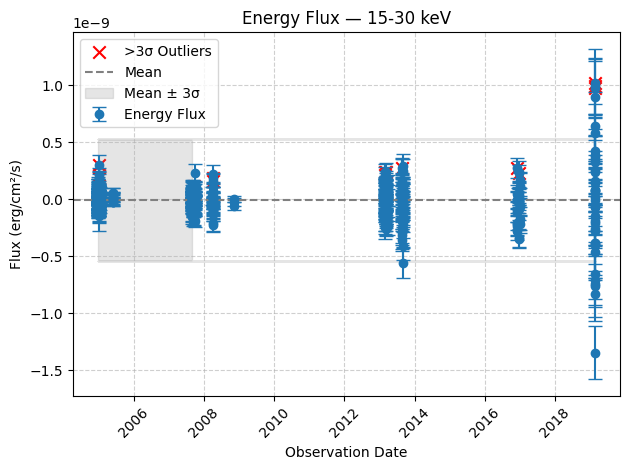

In [9]:
import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

crabYEAR = [
    2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
    2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
]

crabCR = [
    177.78, 187.87, 154.78, 167.87, 178.74, 171.44, 165.48, 166.83, 170.34, 179.76,
    180.38, 177.39, 182.58, 190.21, 176.37, 145.56, 0.00, 0.00, 0.00, 162.07
]

crabERR = [
    0.98, 1.13, 0.90, 0.95, 1.96, 1.35, 1.70, 4.00, 3.67, 2.55,
    4.95, 4.88, 4.57, 8.60, 9.31, 19.22, 0.00, 0.00, 0.00, 15.76
]

ph_flux1, ph_flux1_err, erg_flux1, erg_flux1_err, flux1_date = cr2flux(cr1, vr1, img_times1, crabCR, crabERR, crabYEAR)

# Compute means and thresholds
ph_flux_mean = np.mean(ph_flux1)
ph_flux_std = np.std(ph_flux1)

erg_flux_mean = np.mean(erg_flux1)
erg_flux_std = np.std(erg_flux1)

# Plot photon flux with outliers and thresholds
plt.figure()
plt.errorbar(flux1_date, ph_flux1, yerr=ph_flux1_err, fmt='o', capsize=5, label='Photon Flux')
plt.scatter(np.array(flux1_date)[outliers_idx], np.array(ph_flux1)[outliers_idx],
            color='red', marker='x', s=80, label='>3σ Outliers')
plt.axhline(ph_flux_mean, color='gray', linestyle='--', label='Mean')

plt.fill_between(
    flux1_date,
    ph_flux_mean - 3 * ph_flux_std,
    ph_flux_mean + 3 * ph_flux_std,
    color='gray',
    alpha=0.2,
    label='Mean ± 3σ'
)

plt.xlabel("Observation Date")
plt.ylabel("Flux (photons/cm²/s)")
plt.title("Photon Flux — 15-30 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot energy flux with outliers and thresholds
plt.figure()
plt.errorbar(flux1_date, erg_flux1, yerr=erg_flux1_err, fmt='o', capsize=5, label='Energy Flux')
plt.scatter(np.array(flux1_date)[outliers_idx], np.array(erg_flux1)[outliers_idx],
            color='red', marker='x', s=80, label='>3σ Outliers')
plt.axhline(erg_flux_mean, color='gray', linestyle='--', label='Mean')

plt.fill_between(
    flux1_date,
    erg_flux_mean - 3 * erg_flux_std,
    erg_flux_mean + 3 * erg_flux_std,
    color='gray',
    alpha=0.2,
    label='Mean ± 3σ'
)

plt.xlabel("Observation Date")
plt.ylabel("Flux (erg/cm²/s)")
plt.title("Energy Flux — 15-30 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

print("Flux values for S/N > 3:")
for idx in outliers_idx:
    print(f"Date: {flux1_date[idx]}, Photon Flux: {ph_flux1[idx]:.3e} ± {ph_flux1_err[idx]:.3e}, "
          f"Energy Flux: {erg_flux1[idx]:.3e} ± {erg_flux1_err[idx]:.3e}")
    print(f"File name: {files[idx]}")
    print()

print("Average fluxes:")
print(f"Photon Flux: {ph_flux_mean:.3e} ± {ph_flux_std:.3e}")
print(f"Energy Flux: {erg_flux_mean:.3e} ± {erg_flux_std:.3e}")

In [10]:
# Weighted average and uncertainty
ph_flux_weighted_avg, ph_flux_weighted_err = simple_weighted_average(ph_flux1, ph_flux1_err)
print(f"Weighted Photon Flux: {ph_flux_weighted_avg:.3e} ± {ph_flux_weighted_err:.3e}") # upper limit is this error (well 3sigma times this one, depends what you want)

Weighted Photon Flux: -8.687e-05 ± 7.344e-05


In [11]:
print(f'{ph_flux_weighted_err * 3:.3e}') # photons/cm2/s (3 * sigma weighted error)
print(f'{ph_flux1_err.mean() * 3:.3e}') # photons/cm2/s (3 * sigma average error)
print(f'{np.max([flux for i, flux in enumerate(ph_flux1) if i in outliers_idx]):.3e}') # photons/cm2/s (maximum flux value with S/N > 3)

2.203e-04
6.780e-03
3.076e-02


Monthly light curves

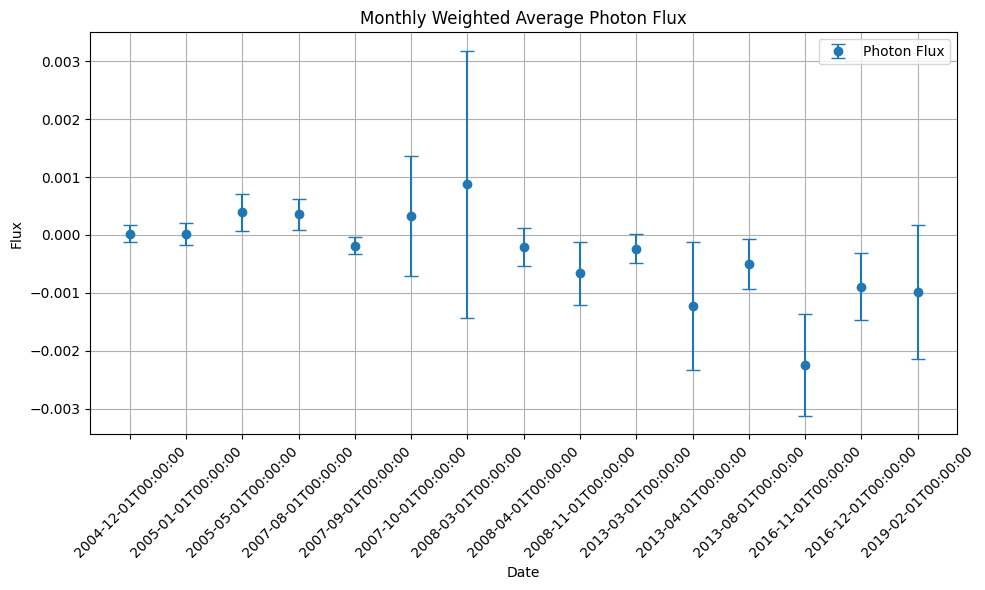

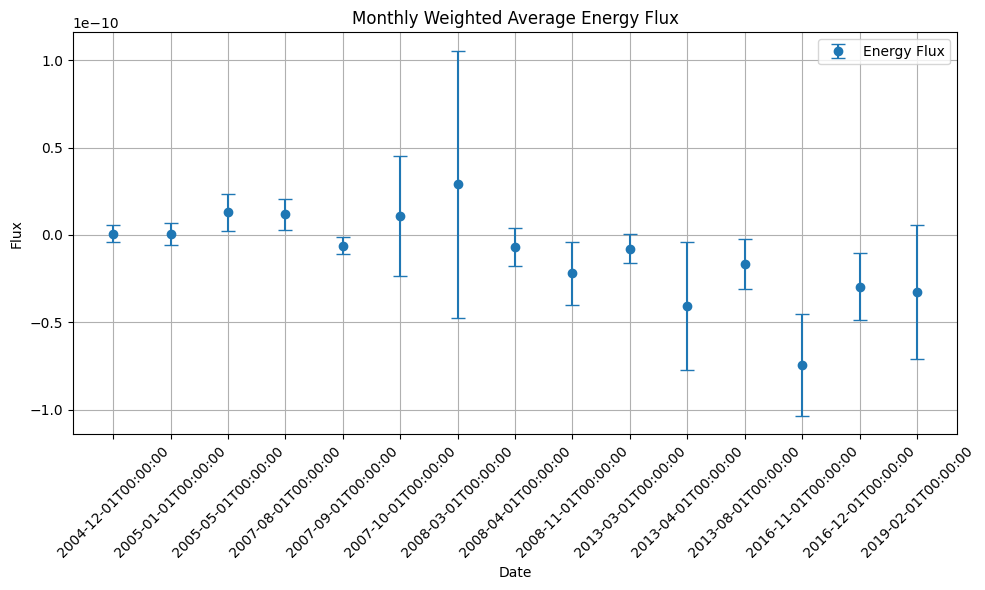

In [12]:
import importlib
plots = importlib.import_module('plots')
importlib.reload(plots)
from plots import *

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

monthly_lightcurve = plot_monthly_flux_lc(ph_flux1, ph_flux1_err, erg_flux1, erg_flux1_err, flux1_date, plot=True)

Comparison with background

Number of detections (S/N > 3): 1
Number of negative detections (S/N < -3): 3

Detection dates:  [datetime.datetime(2019, 2, 23, 15, 51, 50)]
Detection SCWs:  ['206000380010']
Detection fluxes:  [0.02959302]


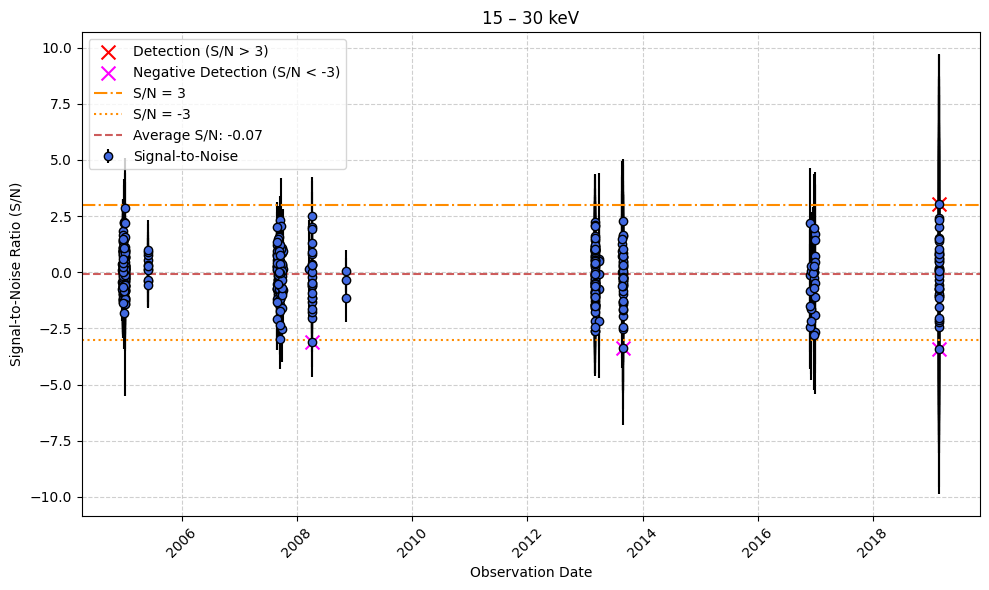

In [140]:
signal = np.array(cr1) - np.array(acr1)
noise = np.sqrt(np.array(vr1) + np.array(avr1))

SNR = signal / noise

detections = SNR > 3
inverse_detections = SNR < -3 

print("Number of detections (S/N > 3):", np.sum(detections))
print("Number of negative detections (S/N < -3):", np.sum(inverse_detections))
print()

jtable = ascii.read('../data/jupiter_table.dat')
jdates = jtable['start_date']
scws = [str(scw).zfill(12) for scw in jtable['scw_id']]

detection_times = np.array(img_times1)[detections]
detection_idxs = [np.argmin(np.abs(jdates - Time(dt).mjd)) for dt in detection_times]
flux_detections = np.array(ph_flux1)[detections]

print("Detection dates: ", detection_times)
print("Detection SCWs: ", [scws[idx] for idx in detection_idxs])
print("Detection fluxes: ", flux_detections)

    
# Plotting S/N over time
plt.figure(figsize=(10, 6))
plt.errorbar(img_times1, SNR, yerr=noise, fmt='o', capsize=0, label='Signal-to-Noise', markerfacecolor='royalblue', markeredgecolor='k', ecolor='k')
plt.scatter(np.array(img_times1)[detections], SNR[detections], color='r', marker='x', s=100, label='Detection (S/N > 3)')
plt.scatter(np.array(img_times1)[inverse_detections], SNR[inverse_detections], color='magenta', marker='x', s=100, label='Negative Detection (S/N < -3)')
plt.axhline(3, color='darkorange', linestyle='-.', label='S/N = 3')
plt.axhline(-3, color='darkorange', linestyle=':', label='S/N = -3')
plt.axhline(np.nanmean(SNR), color='indianred', linestyle='--', label=f'Average S/N: {np.nanmean(SNR):.2f}')
plt.xlabel("Observation Date")
plt.ylabel("Signal-to-Noise Ratio (S/N)")
plt.title("15 – 30 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()

## 30 - 60 keV (ISGRI)

Light curves

## 3 - 15 keV (JEM-X)

In [106]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.time import Time

import importlib
utils = importlib.import_module('utils')
importlib.reload(utils)
from utils import *

In [107]:
# ISGRI: 15 - 30 keV
cr3, vr3, sg3, xp3, acr3, avr3, cr3_cpsf, cr3_psf, err3_cpsf, err3_psf, date3, offset3 = loadJupiterIMG(path='../data/Jupiter/3-15keV/Images', scw_path='../data/jupiter_table.dat', jemx = True)

/home/hthums/master_projects/jupiter-xray-analysis/jupiter-xrays/utils.py:603: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(Gaussian2D_fixed, xy, z, p0=[cr, x_int, y_int])
/home/hthums/master_projects/jupiter-xray-analysis/jupiter-xrays/utils.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(Gaussian2D, xy, z, p0=[cr, x_int, y_int,  np.sqrt(vr),  np.sqrt(vr), 0, 0])


Error processing file 059900370010.001mosaic.fits: list index out of range
Error processing file 026800190010.001mosaic.fits: list index out of range
Error processing file 026800250010.001mosaic.fits: list index out of range
Error processing file 027300140010.001mosaic.fits: list index out of range
Error processing file 027300090010.001mosaic.fits: list index out of range
Error processing file 027300100010.001mosaic.fits: list index out of range
Error processing file 060000450010.001mosaic.fits: list index out of range
Error processing file 059600530010.001mosaic.fits: list index out of range
Error processing file 059500130010.001mosaic.fits: list index out of range
Error processing file 059500510010.001mosaic.fits: list index out of range
Error processing file 026700380010.001mosaic.fits: list index out of range
Error processing file 060400120010.001mosaic.fits: list index out of range
Error processing file 214200080010.001mosaic.fits: index 369 is out of bounds for axis 0 with size 3

In [108]:
len(cr3)

111

Light curves

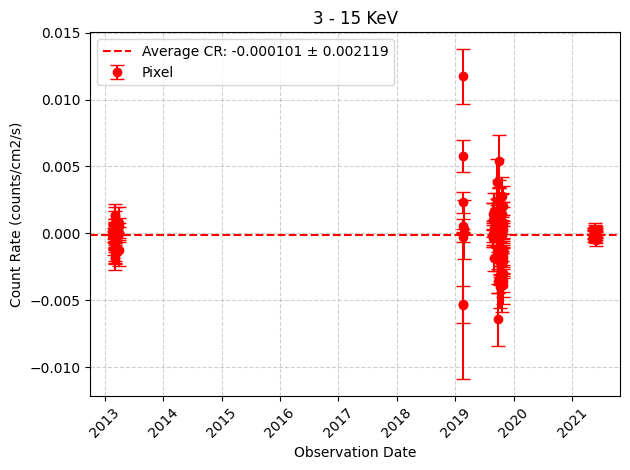

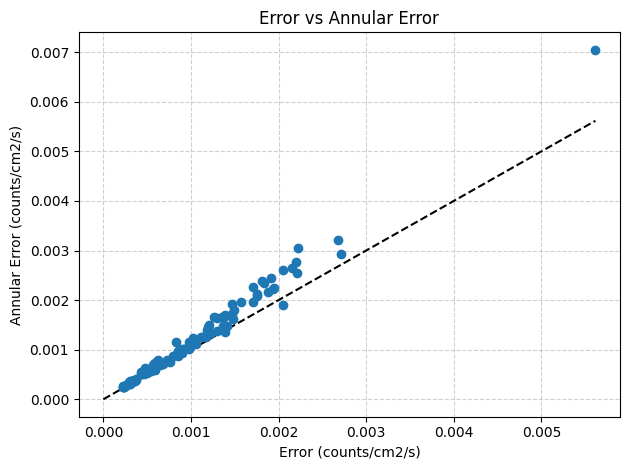

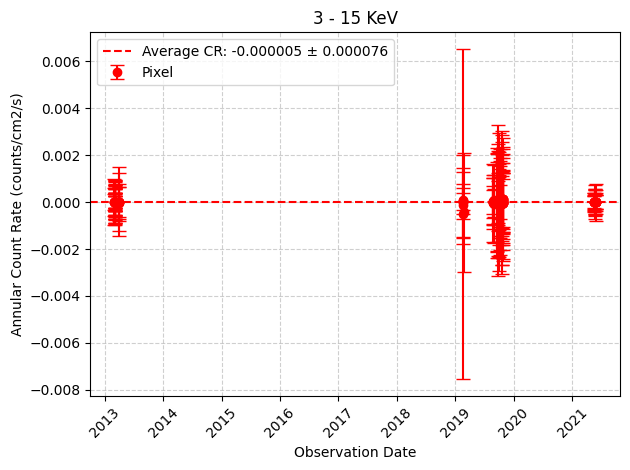

In [153]:
img_times3 = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f") for date in date3]

# Calculate averages and standard deviations
avg_cr3 = np.mean(cr3)
std_cr3 = np.std(cr3)
avg_psf3 = np.mean(cr3_psf)
std_psf3 = np.std(cr3_psf)
avg_cpsf3 = np.mean(cr3_cpsf)
std_cpsf3 = np.std(cr3_cpsf)
avg_acr3 = np.mean(acr3)
std_acr3 = np.std(acr3)

# Plot count rate over time with errorbars and std region
plt.figure()

plt.errorbar(img_times3, cr3, yerr=np.sqrt(vr3), color='r', fmt='o', capsize=5, label='Pixel')
plt.axhline(avg_cr3, color='r', linestyle='--', label=f'Average CR: {avg_cr3:.6f} ± {std_cr3:.6f}')


#plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(img_times3)) if i % 4 == 0], labels=[s for i,s in enumerate(img_times3) if i % 4 == 0])

plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/cm2/s)")
plt.title("3 - 15 KeV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


# Plot error vs annular error
plt.figure()

x = np.linspace(0, np.max(np.sqrt(vr3)), 100)
y = x
plt.plot(x, y, color='k', linestyle='--', label='y=x')

plt.errorbar(np.sqrt(vr3), np.sqrt(avr3), fmt='o', capsize=5)

plt.xlabel("Error (counts/cm2/s)")
plt.ylabel("Annular Error (counts/cm2/s)")
plt.title("Error vs Annular Error")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Plot annular count rate
plt.figure()

plt.errorbar(img_times3, acr3, yerr=np.sqrt(avr3), color='r', fmt='o', capsize=5, label='Pixel')
plt.axhline(avg_acr3, color='r', linestyle='--', label=f'Average CR: {avg_acr3:.6f} ± {std_acr3:.6f}')

plt.xlabel("Observation Date")
plt.ylabel("Annular Count Rate (counts/cm2/s)")
plt.title("3 - 15 KeV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()


Statistics

Images corresponding to S/N > 3:
Date: 2019-02-20 06:43:12.403000, S/N: 5.730918309674709
File name: ../data/Jupiter/3-15keV/Images/126800100010.001mosaic.fits
Max count rate value: 0.011738497857266562
Index in list: 42
MJD date: 58534.28000466435
ScW name: 205900180010

Date: 2019-02-19 21:34:59.381000, S/N: 4.882963115237492
File name: ../data/Jupiter/3-15keV/Images/059600440010.001mosaic.fits
Max count rate value: 0.011738497857266562
Index in list: 43
MJD date: 58533.8992983912
ScW name: 205900070010

Date: 2019-02-19 23:14:41.385000, S/N: 3.0268119591932012
File name: ../data/Jupiter/3-15keV/Images/237000460010.001mosaic.fits
Max count rate value: 0.011738497857266562
Index in list: 106
MJD date: 58533.968534548614
ScW name: 205900090010



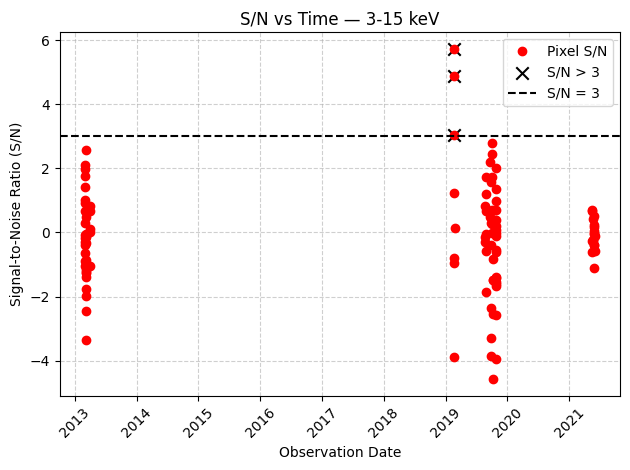

In [110]:
snr_cr3 = np.array(cr3) / np.sqrt(vr3)
annular_snr_cr3 = np.array(cr3_cpsf) / np.sqrt(avr3)

plt.figure()
plt.plot(img_times3, snr_cr3, 'o', color='r', label='Pixel S/N')
#plt.plot(img_times3, annular_snr_cr3, 'o', color='b', label='Annular S/N')

outliers_idx3 = [i for i, snr in enumerate(snr_cr3) if snr > 3]
plt.scatter(
    [img_times3[i] for i in outliers_idx3],
    [snr_cr3[i] for i in outliers_idx3],
    marker='x',
    color='k',
    s=80,
    label='S/N > 3'
)

plt.axhline(3, color='k', linestyle='--', label='S/N = 3')

#plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(img_times3)) if i % 8 == 0], labels=[s for i,s in enumerate(img_times3) if i % 8 == 0])

plt.xlabel("Observation Date")
plt.ylabel("Signal-to-Noise Ratio (S/N)")
plt.title("S/N vs Time — 3-15 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

files3 = glob.glob(f'../data/Jupiter/3-15keV/Images/*')

print("Images corresponding to S/N > 3:")
for idx in outliers_idx3:
    print(f"Date: {img_times3[idx]}, S/N: {snr_cr3[idx]}")
    print(f"File name: {files3[idx]}")
    print(f"Max count rate value: {np.max(cr3)}")
    print(f"Index in list: {idx}")
    print(f"MJD date: {Time(date3[idx]).mjd}")
    jupitertable = ascii.read('../data/jupiter_table.dat')
    idx_ = np.argmin(np.abs(Time(date3[idx]).mjd - jupitertable['start_date']))
    print(f"ScW name: {jupitertable['scw_id'][idx_]}")
    print()

In [111]:
Time(56353.4369100363, format='mjd').datetime

datetime.datetime(2013, 3, 2, 10, 29, 9, 27136)

Total points: 111
Observed points beyond 3σ: 9
Expected points beyond 3σ: 0.30
Observed fraction: 8.11%
Expected fraction: 0.27%


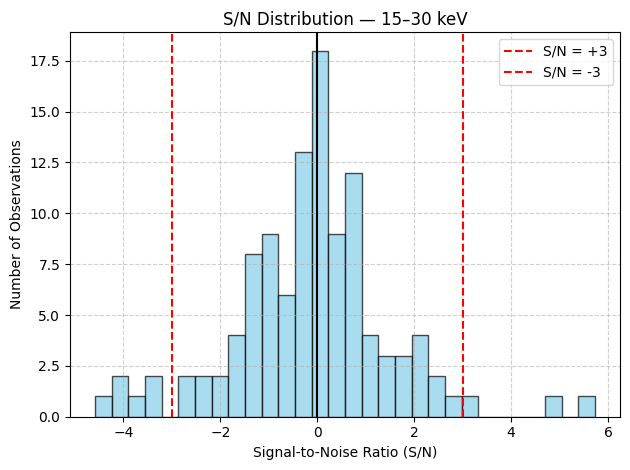

In [112]:
plt.figure()
plt.hist(snr_cr3, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(0, color='k', linestyle='-')
plt.axvline(3, color='r', linestyle='--', label='S/N = +3')
plt.axvline(-3, color='r', linestyle='--', label='S/N = -3')
plt.xlabel("Signal-to-Noise Ratio (S/N)")
plt.ylabel("Number of Observations")
plt.title("S/N Distribution — 15–30 keV")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

snr = np.array(cr3) / np.sqrt(vr3)
outliers = (snr > 3) | (snr < -3)
n_outliers = np.sum(outliers)

n_total = len(snr)
n_expected = 0.0027 * n_total # theoretical fraction of outliers in a normal distribution

print(f"Total points: {n_total}")
print(f"Observed points beyond 3σ: {n_outliers}")
print(f"Expected points beyond 3σ: {n_expected:.2f}")
print(f"Observed fraction: {n_outliers/n_total *100:.2f}%")
print(f"Expected fraction: 0.27%")

Flux conversion

In [113]:
crabYEAR3 = [
    2004, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
    2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
]

crabCR3 = [
    0.1062, 0.1117, 0.1016, 0.1225, 0.1105, 0.1025, 0.1330, 0.1221,
    0.1181, 0.1254, 0.1235, 0.1116, 0.1345, 0.1373, 0.1046, 0.0949,
    0.1279, 0.1477
]

crabERR3 = [
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000
]


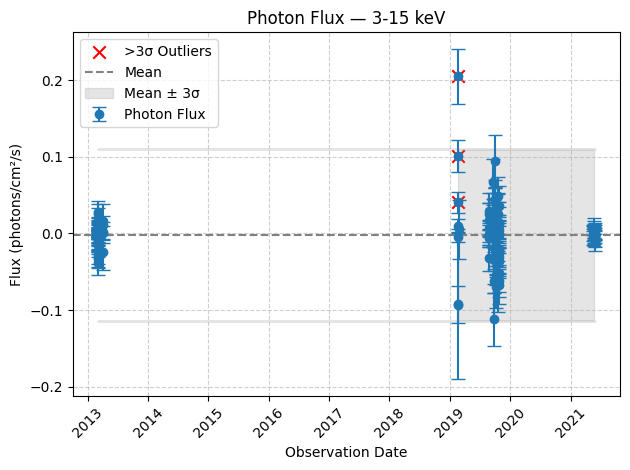

In [114]:
ph_flux3, ph_flux3_err, erg_flux3, erg_flux3_err, flux3_date = cr2flux(cr3, vr3, img_times3, crabCR3, crabERR3, crabYEAR3, instrument='JEM-X', energy_range=(3, 15))

ph_flux_mean = np.mean(ph_flux3)
ph_flux_std = np.std(ph_flux3)

plt.figure()
plt.errorbar(flux3_date, ph_flux3, yerr=ph_flux3_err, fmt='o', capsize=5, label='Photon Flux')
plt.scatter(np.array(flux3_date)[outliers_idx3], np.array(ph_flux3)[outliers_idx3],
            color='red', marker='x', s=80, label='>3σ Outliers')
plt.axhline(ph_flux_mean, color='gray', linestyle='--', label='Mean')

plt.fill_between(flux3_date, ph_flux_mean - 3 * ph_flux_std, ph_flux_mean + 3 * ph_flux_std,
                 color='gray', alpha=0.2, label='Mean ± 3σ')

plt.xlabel("Observation Date")
plt.ylabel("Flux (photons/cm²/s)")
plt.title("Photon Flux — 3-15 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

In [115]:
# Weighted average and uncertainty
ph_flux_weighted_avg3, ph_flux_weighted_err3 = simple_weighted_average(ph_flux3, ph_flux3_err)

print(f"Weighted Photon Flux: {ph_flux_weighted_avg3:.3e} ± {ph_flux_weighted_err3:.3e}") # upper limit is this error (well 3sigma times this one, depends what you want)

print(f'{ph_flux_weighted_err3 * 3:.3e}') # photons/cm2/s (3 * sigma weighted error)
print(f'{np.max([flux for i, flux in enumerate(ph_flux3) if (i in outliers_idx3 and flux<1000)]):.3e}') # photons/cm2/s (maximum flux value with S/N > 3)

Weighted Photon Flux: -8.001e-04 ± 9.965e-04
2.990e-03
2.052e-01


Comparison with background

Number of detections (S/N > 3): 2
Number of negative detections (S/N < -3): 1

Detection dates:  [datetime.datetime(2019, 2, 20, 6, 43, 12, 403000)
 datetime.datetime(2019, 2, 19, 21, 34, 59, 381000)]
Detection SCWs:  ['205900180010', '205900070010']
Detection fluxes:  [0.20515341 0.10134465]
Flux values for S/N > 3: [0.20515341 0.10134465]


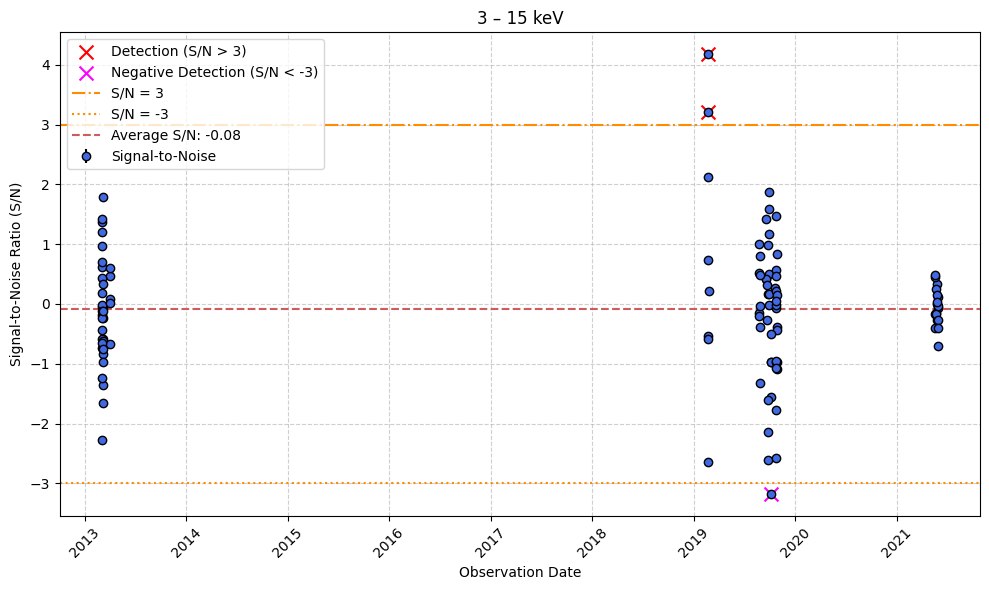

In [146]:
signal = np.array(cr3) - np.array(acr3)
noise = np.sqrt(np.array(vr3) + np.array(avr3))

SNR = signal / noise

detections = SNR > 3
inverse_detections = SNR < -3 

print("Number of detections (S/N > 3):", np.sum(detections))
print("Number of negative detections (S/N < -3):", np.sum(inverse_detections))
print()

jtable = ascii.read('../data/jupiter_table.dat')
jdates = jtable['start_date']
scws = [str(scw).zfill(12) for scw in jtable['scw_id']]

detection_times = np.array(img_times3)[detections]
detection_idxs = [np.argmin(np.abs(jdates - Time(dt).mjd)) for dt in detection_times]
flux_detections = np.array(ph_flux3)[detections]

print("Detection dates: ", detection_times)
print("Detection SCWs: ", [scws[idx] for idx in detection_idxs])
print("Detection fluxes: ", flux_detections)

# sanity check: convert manually the count rate with S/N > 3 to flux
max_SNR_cr3 = np.array(cr3)[detections]
max_SNR_vr3 = np.array(vr3)[detections]
crab_cr3_2019 = 0.1373
flux3, _, _, _, _ = cr2flux(max_SNR_cr3, max_SNR_vr3, detection_times, [0.1373], [0], [2019], instrument="JEM-X", energy_range=(3, 15))
print("Flux values for S/N > 3:", flux3)

# Plotting S/N over time
plt.figure(figsize=(10, 6))
plt.errorbar(img_times3, SNR, yerr=noise, fmt='o', capsize=0, label='Signal-to-Noise', markerfacecolor='royalblue', markeredgecolor='k', ecolor='k')
plt.scatter(np.array(img_times3)[detections], SNR[detections], color='r', marker='x', s=100, label='Detection (S/N > 3)')
plt.scatter(np.array(img_times3)[inverse_detections], SNR[inverse_detections], color='magenta', marker='x', s=100, label='Negative Detection (S/N < -3)')
plt.axhline(3, color='darkorange', linestyle='-.', label='S/N = 3')
plt.axhline(-3, color='darkorange', linestyle=':', label='S/N = -3')
plt.axhline(np.nanmean(SNR), color='indianred', linestyle='--', label=f'Average S/N: {np.nanmean(SNR):.2f}')
plt.xlabel("Observation Date")
plt.ylabel("Signal-to-Noise Ratio (S/N)")
plt.title("3 – 15 keV")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()